In [377]:
import pandas as pd
import os
import numpy as np
import re
import itertools
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
from xgboost import XGBClassifier


In [378]:
BASE_DIR = "data"


def load_csv(filename):
    return pd.read_csv(os.path.join(BASE_DIR, filename))


teams = load_csv("WTeams.csv")
seasons = load_csv("WSeasons.csv")
tourney_seeds = load_csv("WNCAATourneySeeds.csv")
regular_season_results = load_csv("WRegularSeasonCompactResults.csv")
tourney_results = load_csv("WNCAATourneyCompactResults.csv")
regular_season_detailed = load_csv("WRegularSeasonDetailedResults.csv")
tourney_detailed = load_csv("WNCAATourneyDetailedResults.csv")


In [379]:
datasets = {
    "Teams": teams,
    "Seasons": seasons,
    "Tourney Seeds": tourney_seeds,
    "Regular Season Results": regular_season_results,
    "Tourney Results": tourney_results,
    "Regular Season Detailed": regular_season_detailed,
    "Tourney Detailed": tourney_detailed
}

for name, df in datasets.items():
    print(f"\n{name} Dataset Sample:")
    print(df.head(), "\n")



Teams Dataset Sample:
   TeamID     TeamName
0    3101  Abilene Chr
1    3102    Air Force
2    3103        Akron
3    3104      Alabama
4    3105  Alabama A&M 


Seasons Dataset Sample:
   Season     DayZero RegionW  RegionX  RegionY  RegionZ
0    1998  10/27/1997    East  Midwest  Mideast     West
1    1999  10/26/1998    East  Mideast  Midwest     West
2    2000  11/01/1999    East  Midwest  Mideast     West
3    2001  10/30/2000    East  Midwest  Mideast     West
4    2002  10/29/2001    East     West  Mideast  Midwest 


Tourney Seeds Dataset Sample:
   Season Seed  TeamID
0    1998  W01    3330
1    1998  W02    3163
2    1998  W03    3112
3    1998  W04    3301
4    1998  W05    3272 


Regular Season Results Dataset Sample:
   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0    1998      18     3104      91     3202      41    H      0
1    1998      18     3163      87     3221      76    H      0
2    1998      18     3222      66     3261      59    H      0
3

In [380]:
tourney_results["HomeWinBonus"] = (tourney_results["WLoc"] == "H").astype(int)


In [381]:
tourney_results = tourney_results.merge(
    tourney_seeds, how="left", left_on=["Season", "WTeamID"], right_on=["Season", "TeamID"]
).rename(columns={"Seed": "WSeed"})

tourney_results = tourney_results.merge(
    tourney_seeds, how="left", left_on=["Season", "LTeamID"], right_on=["Season", "TeamID"]
).rename(columns={"Seed": "LSeed"})

# Drop duplicate TeamID columns
tourney_results.drop(columns=["TeamID_x", "TeamID_y"], inplace=True)

print("✅ Tournament Seeds Merged")


✅ Tournament Seeds Merged


In [382]:
regular_season_summary = regular_season_results.groupby(["Season", "WTeamID"]).agg({
    "WScore": "mean",
    "LScore": "mean",
    "NumOT": "mean"
}).reset_index().rename(
    columns={"WTeamID": "TeamID", "WScore": "AvgPointsScored", "LScore": "AvgPointsConceded", "NumOT": "AvgOT"})

tourney_results = tourney_results.merge(
    regular_season_summary, how="left", left_on=["Season", "WTeamID"], right_on=["Season", "TeamID"]
).rename(columns={"AvgPointsScored": "WAvgPointsScored", "AvgPointsConceded": "WAvgPointsConceded", "AvgOT": "WAvgOT"})

tourney_results = tourney_results.merge(
    regular_season_summary, how="left", left_on=["Season", "LTeamID"], right_on=["Season", "TeamID"]
).rename(columns={"AvgPointsScored": "LAvgPointsScored", "AvgPointsConceded": "LAvgPointsConceded", "AvgOT": "LAvgOT"})

# Drop duplicate TeamID columns
tourney_results.drop(columns=["TeamID_x", "TeamID_y"], inplace=True)

print("✅ Regular Season Performance Merged")


✅ Regular Season Performance Merged


In [383]:
# Convert seed values from string to numeric
tourney_results["WSeed"] = tourney_results["WSeed"].astype(str).str.extract("(\d+)").astype(float)
tourney_results["LSeed"] = tourney_results["LSeed"].astype(str).str.extract("(\d+)").astype(float)

# Compute Seed Difference
tourney_results["SeedDiff"] = tourney_results["WSeed"] - tourney_results["LSeed"]


<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Emmanuel Okunfolami\AppData\Local\Temp\ipykernel_9508\803557826.py:2: SyntaxWarning: invalid escape sequence '\d'
  tourney_results["WSeed"] = tourney_results["WSeed"].astype(str).str.extract("(\d+)").astype(float)
C:\Users\Emmanuel Okunfolami\AppData\Local\Temp\ipykernel_9508\803557826.py:3: SyntaxWarning: invalid escape sequence '\d'
  tourney_results["LSeed"] = tourney_results["LSeed"].astype(str).str.extract("(\d+)").astype(float)


In [384]:
tourney_results["W_OffensiveRating"] = tourney_results["WAvgPointsScored"] - tourney_results["LAvgPointsConceded"]
tourney_results["L_OffensiveRating"] = tourney_results["LAvgPointsScored"] - tourney_results["WAvgPointsConceded"]

tourney_results["W_DefensiveRating"] = tourney_results["WAvgPointsConceded"] - tourney_results["LAvgPointsScored"]
tourney_results["L_DefensiveRating"] = tourney_results["LAvgPointsConceded"] - tourney_results["WAvgPointsScored"]


In [385]:
tourney_results_flipped = tourney_results.copy()

# Swap winning and losing team stats
tourney_results_flipped["SeedDiff"] *= -1
tourney_results_flipped["W_OffensiveRating"], tourney_results_flipped["L_OffensiveRating"] = (
    tourney_results_flipped["L_OffensiveRating"],
    tourney_results_flipped["W_OffensiveRating"],
)
tourney_results_flipped["W_DefensiveRating"], tourney_results_flipped["L_DefensiveRating"] = (
    tourney_results_flipped["L_DefensiveRating"],
    tourney_results_flipped["W_DefensiveRating"],
)

# Change the target label (flipping the match outcome)
tourney_results_flipped["WinLabel"] = 0

# Combine the original and flipped datasets
final_dataset = pd.concat([tourney_results, tourney_results_flipped], ignore_index=True)

# Shuffle the dataset
final_dataset = final_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Check if we now have both classes
print(f"✅ Class Distribution: \n{final_dataset['WinLabel'].value_counts()}")


✅ Class Distribution: 
WinLabel
0.0    1650
Name: count, dtype: int64


In [386]:
print("Missing values in y:", y.isnull().sum())


Missing values in y: 0


In [387]:
print("Missing values in y after cleaning:", y.isnull().sum())


Missing values in y after cleaning: 0


In [388]:
print("Class distribution in y_train:\n", y_train.value_counts())


Class distribution in y_train:
 WinLabel
1    508655
0    508359
Name: count, dtype: int64


In [389]:
print("Class distribution in full dataset:\n", final_dataset["WinLabel"].value_counts())


Class distribution in full dataset:
 WinLabel
0.0    1650
Name: count, dtype: int64


In [390]:
# Compute Win/Loss Streaks
regular_season_results["WinStreak"] = regular_season_results.groupby(["Season", "WTeamID"]).cumcount() + 1
regular_season_results["LoseStreak"] = regular_season_results.groupby(["Season", "LTeamID"]).cumcount() + 1

# Merge Win/Loss streaks with tournament results
final_dataset = final_dataset.merge(
    regular_season_results[["Season", "WTeamID", "WinStreak"]],
    how="left", left_on=["Season", "WTeamID"], right_on=["Season", "WTeamID"]
).rename(columns={"WinStreak": "WWinStreak"})

final_dataset = final_dataset.merge(
    regular_season_results[["Season", "LTeamID", "LoseStreak"]],
    how="left", left_on=["Season", "LTeamID"], right_on=["Season", "LTeamID"]
).rename(columns={"LoseStreak": "LLoseStreak"})

# Compute Point Differential
final_dataset["PointDiff"] = final_dataset["WAvgPointsScored"] - final_dataset["LAvgPointsScored"]

# Fill missing values with 0
final_dataset["WWinStreak"].fillna(0, inplace=True)
final_dataset["LLoseStreak"].fillna(0, inplace=True)
final_dataset["PointDiff"].fillna(0, inplace=True)

print("✅ Features computed before balancing!")


✅ Features computed before balancing!


C:\Users\Emmanuel Okunfolami\AppData\Local\Temp\ipykernel_9508\1574382924.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_dataset["WWinStreak"].fillna(0, inplace=True)
C:\Users\Emmanuel Okunfolami\AppData\Local\Temp\ipykernel_9508\1574382924.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

In [391]:
print("Missing values in y:", y.isnull().sum())


Missing values in y: 0


In [392]:
# Display a few rows where `WinLabel` is missing
missing_rows = final_dataset[final_dataset["WinLabel"].isnull()]
print("Rows with missing WinLabel:\n", missing_rows.head())

# Count missing values in the entire dataset
print("Missing values per column:\n", final_dataset.isnull().sum())


Rows with missing WinLabel:
    Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  HomeWinBonus  \
0    1998     145     3301      55     3330      54    A      0             0   
1    1998     145     3301      55     3330      54    A      0             0   
2    1998     145     3301      55     3330      54    A      0             0   
3    1998     145     3301      55     3330      54    A      0             0   
4    1998     145     3301      55     3330      54    A      0             0   

   WSeed  ...  LAvgOT  SeedDiff  W_OffensiveRating  L_OffensiveRating  \
0    4.0  ...     0.0       3.0          19.704762          23.110476   
1    4.0  ...     0.0       3.0          19.704762          23.110476   
2    4.0  ...     0.0       3.0          19.704762          23.110476   
3    4.0  ...     0.0       3.0          19.704762          23.110476   
4    4.0  ...     0.0       3.0          19.704762          23.110476   

   W_DefensiveRating  L_DefensiveRating  WinL

In [393]:
# If WTeamID exists, set WinLabel = 1 (Winning Team), otherwise 0
final_dataset["WinLabel"] = final_dataset["WTeamID"].notnull().astype(int)

print("✅ Recomputed `WinLabel` successfully!")


✅ Recomputed `WinLabel` successfully!


In [394]:
print("Missing values in WinLabel after fixing:", final_dataset["WinLabel"].isnull().sum())


Missing values in WinLabel after fixing: 0


In [395]:
print("Available columns in final_dataset:", final_dataset.columns.tolist())


Available columns in final_dataset: ['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc', 'NumOT', 'HomeWinBonus', 'WSeed', 'LSeed', 'WAvgPointsScored', 'WAvgPointsConceded', 'WAvgOT', 'LAvgPointsScored', 'LAvgPointsConceded', 'LAvgOT', 'SeedDiff', 'W_OffensiveRating', 'L_OffensiveRating', 'W_DefensiveRating', 'L_DefensiveRating', 'WinLabel', 'WWinStreak', 'LLoseStreak', 'PointDiff']


In [396]:
# Print class distribution
print("Class distribution in WinLabel:\n", final_dataset["WinLabel"].value_counts())


Class distribution in WinLabel:
 WinLabel
1    635634
Name: count, dtype: int64


In [397]:
# Duplicate and flip matches to create losses
tourney_results_flipped = final_dataset.copy()

# Swap team-related stats for losing team as winning team
tourney_results_flipped["SeedDiff"] *= -1
tourney_results_flipped["W_OffensiveRating"], tourney_results_flipped["L_OffensiveRating"] = (
    tourney_results_flipped["L_OffensiveRating"],
    tourney_results_flipped["W_OffensiveRating"],
)
tourney_results_flipped["W_DefensiveRating"], tourney_results_flipped["L_DefensiveRating"] = (
    tourney_results_flipped["L_DefensiveRating"],
    tourney_results_flipped["W_DefensiveRating"],
)

# Swap Win/Loss Streaks
tourney_results_flipped["WWinStreak"], tourney_results_flipped["LLoseStreak"] = (
    tourney_results_flipped["LLoseStreak"],
    tourney_results_flipped["WWinStreak"],
)

# Flip Point Differential
tourney_results_flipped["PointDiff"] *= -1

# Flip WinLabel (change 1 → 0 and 0 → 1)
tourney_results_flipped["WinLabel"] = 1 - tourney_results_flipped["WinLabel"]

# Combine original and flipped datasets
final_dataset = pd.concat([final_dataset, tourney_results_flipped], ignore_index=True)

# Shuffle the dataset
final_dataset = final_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new class distribution
print("✅ Class distribution after balancing:\n", final_dataset["WinLabel"].value_counts())


✅ Class distribution after balancing:
 WinLabel
0    635634
1    635634
Name: count, dtype: int64


In [398]:
# Print column names from the original DataFrame before scaling
print("Training features:", list(X.columns))  # Use X, not X_train
print("New matchups features:", list(X_new.columns))  # X_new should be a DataFrame


Training features: ['SeedDiff', 'W_OffensiveRating', 'L_OffensiveRating', 'W_DefensiveRating', 'L_DefensiveRating', 'HomeWinBonus', 'WWinStreak', 'LLoseStreak', 'PointDiff']
New matchups features: ['SeedDiff', 'W_OffensiveRating', 'L_OffensiveRating', 'W_DefensiveRating', 'L_DefensiveRating', 'HomeWinBonus', 'WWinStreak', 'LLoseStreak', 'PointDiff']


In [399]:
features = ["SeedDiff", "W_OffensiveRating", "L_OffensiveRating",
            "W_DefensiveRating", "L_DefensiveRating", "HomeWinBonus","WWinStreak", "LLoseStreak", "PointDiff"]

X = final_dataset[features]  # Use balanced dataset
y = final_dataset["WinLabel"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

xgb_model = XGBClassifier(objective="binary:logistic", eval_metric="logloss", random_state=42)
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [400]:
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix

y_pred_log = log_reg.predict(X_test)
y_pred_proba_log = log_reg.predict_proba(X_test)[:, 1]

log_accuracy = accuracy_score(y_test, y_pred_log)
log_loss_score = log_loss(y_test, y_pred_proba_log)

print(f"✅ Logistic Regression Accuracy: {log_accuracy:.4f}")
print(f"✅ Logistic Regression Log Loss: {log_loss_score:.4f}")

y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_loss_score = log_loss(y_test, y_pred_proba_xgb)

print(f"✅ XGBoost Accuracy: {xgb_accuracy:.4f}")
print(f"✅ XGBoost Log Loss: {xgb_loss_score:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred_xgb)
print("\nConfusion Matrix (XGBoost):\n", conf_matrix)


✅ Logistic Regression Accuracy: 0.8617
✅ Logistic Regression Log Loss: 0.2916
✅ XGBoost Accuracy: 0.9605
✅ XGBoost Log Loss: 0.1029

Confusion Matrix (XGBoost):
 [[122473   4802]
 [  5251 121728]]


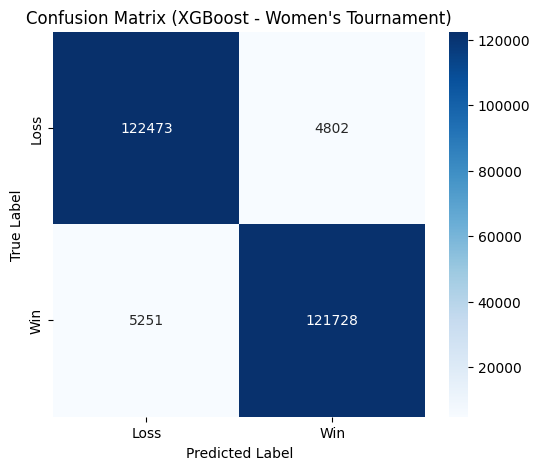

In [401]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions
y_pred_xgb_women = xgb_model.predict(X_test)  # Replace 'xgb_model' with your trained women's model variable
cm_women = confusion_matrix(y_test, y_pred_xgb_women)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_women, annot=True, fmt="d", cmap="Blues", xticklabels=["Loss", "Win"], yticklabels=["Loss", "Win"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (XGBoost - Women's Tournament)")
plt.show()


In [402]:
import joblib

# Save the Logistic Regression model
joblib.dump(log_reg, "Women_logistic_regression_model.pkl")

# Save the XGBoost model
joblib.dump(xgb_model, "Women_xgboost_model.pkl")

# Save the Scaler
joblib.dump(scaler, "Women_scaler.pkl")

print("✅ Models and scaler saved successfully!")


✅ Models and scaler saved successfully!


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200],  # Reduce from [100, 200, 300] → [100, 200]
    "learning_rate": [0.01, 0.1],  # Reduce from [0.01, 0.05, 0.1] → [0.01, 0.1]
    "max_depth": [3, 5],  # Reduce from [3, 5, 7] → [3, 5]
    "subsample": [0.8, 1.0],  # Reduce from [0.7, 0.8, 1.0] → [0.8, 1.0]
    "colsample_bytree": [0.8, 1.0],  # Reduce from [0.7, 0.8, 1.0] → [0.8, 1.0]
    "gamma": [0, 0.1],  # Reduce from [0, 0.1, 0.2] → [0, 0.1]
}

xgb_model = XGBClassifier(objective="binary:logistic", eval_metric="logloss", random_state=42)

grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring="accuracy", verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("✅ Best Parameters:", grid_search.best_params_)

xgb_best = XGBClassifier(**grid_search.best_params_, objective="binary:logistic", eval_metric="logloss",
                         random_state=42)
xgb_best.fit(X_train, y_train)

y_pred_xgb_tuned = xgb_best.predict(X_test)
y_pred_proba_xgb_tuned = xgb_best.predict_proba(X_test)[:, 1]

xgb_tuned_accuracy = accuracy_score(y_test, y_pred_xgb_tuned)
xgb_tuned_logloss = log_loss(y_test, y_pred_proba_xgb_tuned)

print(f"✅ XGBoost Tuned Accuracy: {xgb_tuned_accuracy:.4f}")
print(f"✅ XGBoost Tuned Log Loss: {xgb_tuned_logloss:.4f}")

joblib.dump(xgb_best, "xgboost_women_march_madness_tuned.pkl")
print("✅ Tuned model saved as xgboost_women_march_madness_tuned.pkl")


Fitting 3 folds for each of 64 candidates, totalling 192 fits
